In [16]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
plt.style.use('classic')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [17]:
lts_list = ['0-7', '2-22', '3-22', '6-35', '7-24', '9-21', '11-22', '12-14', '12-26', '13-11', '13-19', '14-27', '15-3', '16-11']
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# RQ0. Distribution
​
In this section, we respond the following two questions:
​
- How are packages distributed in stackage?
- How are packages using mtl distributed in Stackage?
​
For this, we make the following graphs
​
1. Line graph that shows the number of packets for each published snapshot over time
2. Bar graph that shows the evolution of the main categories of the packages
3. Bar graph that shows the evolution of the stabilities of the packages
4. Bar graph that shows the evolution of the main categories of the packages that depend of `mtl`
5. Bar graph that shows the evolution of the stabilities of the packages that depend of `mtl`
​
## RQ0. 1 - Line graph that shows the number of packets for each published snapshot over time

In [18]:
total_pkgs = []
lts_datetim = [
    datetime(2014,12,27), 
    datetime(2015,8,9), 
    datetime(2016,1,10), 
    datetime(2017,6,5), 
    datetime(2017,5,28), 
    datetime(2017,12,28), 
    datetime(2018,8,18), 
    datetime(2018,10,21), 
    datetime(2018,12,30), 
    datetime(2019,3,8), 
    datetime(2019,4,29), 
    datetime(2020,2,15), 
    datetime(2020,3,7), 
    datetime(2020,8,25)
]
lts_date = ["2014-12"]
dates = [datetime(2014,12,1)]
year = 2015
for i in range (6):
    month = 0
    for i in range (4):
        month += 3
        x = year
        y = str(month)
        date = str(x)+"-"+str(y)
        formato = datetime(year,month,1)
        lts_date.append(date)
        dates.append(formato)
    year += 1
    
dates = matplotlib.dates.date2num(dates)
for df in df_list:
    total_pkgs.append(len(df))

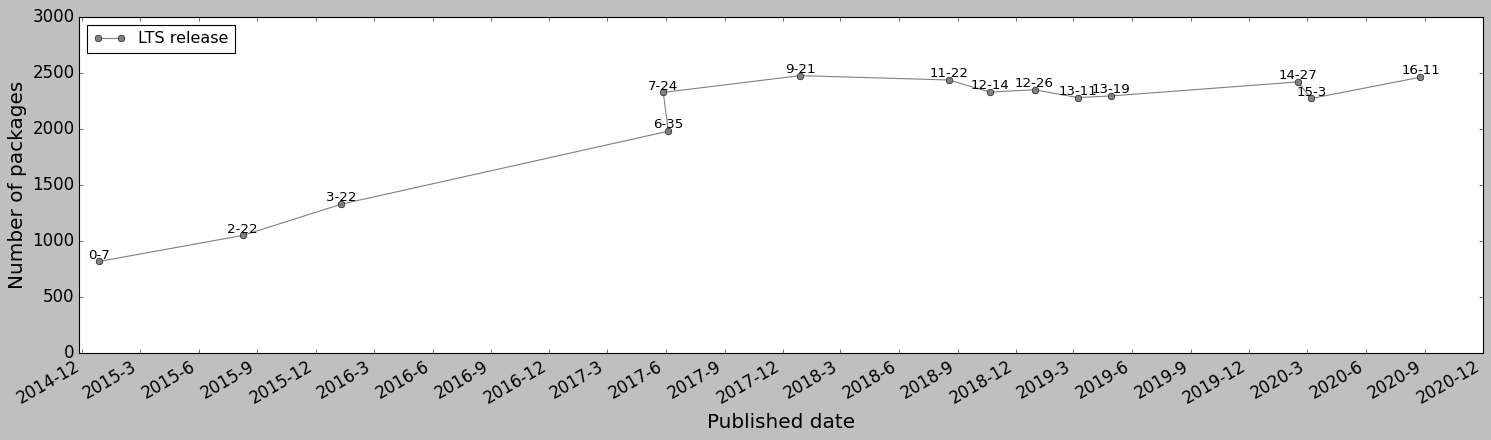

In [19]:
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(18,6))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)


#line = ax.plot(dates, total_pkgs, color='grey', marker='o',label='lts version')
plt.plot_date(lts_datetim, total_pkgs, linestyle='solid',color='grey',label='LTS release')
plt.gcf().autofmt_xdate()

for i in range(len(lts_list)):
    plt.text(lts_datetim[i],total_pkgs[i],lts_list[i],ha="center",va="bottom")

ax.set_yticks([0,500, 1000, 1500, 2000, 2500, 3000])
ax.set_yticklabels(['0','500', '1000', '1500', '2000', '2500', '3000'],fontsize=15)
ax.set_xticks(dates)
ax.set_xticklabels(lts_date,fontsize=15)
ax.set_xlabel('Published date',fontsize=18)
ax.set_ylabel('Number of packages',fontsize=18)
ax.legend(loc='upper left')
plt.savefig("../../graphs/rq0-1.pdf", format='pdf', bbox_inches='tight')
plt.show()